In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roshan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roshan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\roshan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
messages = pd.read_csv('./../data/SMSSpamCollection', sep='\t', names=["label", "message"])

# Data Cleaning

In [3]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### No missing values
### Removing duplicates

In [4]:
print(f"Count of duplicate records: {messages.duplicated().sum()}")
messages = messages.drop_duplicates(keep="first")
print(f"Count of duplicate records: {messages.duplicated().sum()}")

Count of duplicate records: 403
Count of duplicate records: 0


# Exploratory Data Analysis

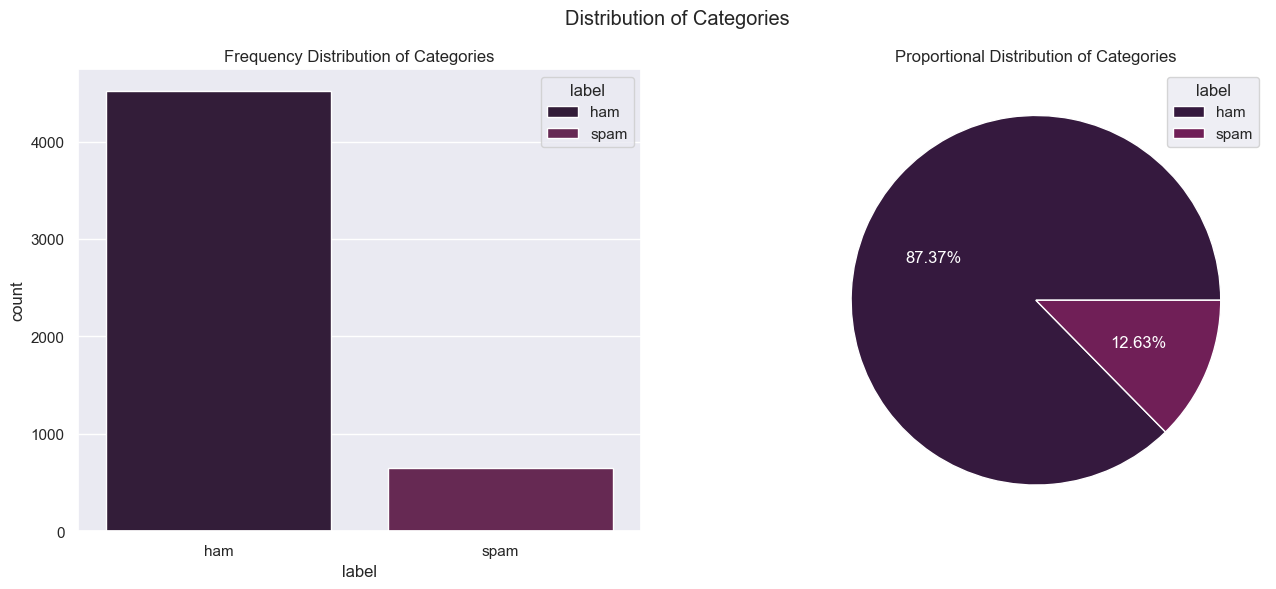

In [5]:
sns.set_theme(style="darkgrid", palette="rocket")

plt.figure(figsize=(16, 6))
plt.suptitle("Distribution of Categories")

plt.subplot(1, 2, 1)
plt.title("Frequency Distribution of Categories")
sns.countplot(data=messages, x="label", hue="label", legend="full")

distribution = messages["label"].value_counts()
plt.subplot(1, 2, 2)
plt.title("Proportional Distribution of Categories")
plt.pie(distribution, labels=distribution.index, autopct="%0.2f%%", textprops={"color": "#FFF"})
plt.legend(title="label")

plt.show()

In [6]:
messages["char_count"] = messages["message"].apply(len)
messages["word_count"] = messages["message"].apply(lambda x: len(nltk.word_tokenize(x)))
messages["sent_count"] = messages["message"].apply(lambda x: len(nltk.sent_tokenize(x)))

In [7]:
messages.head()

,label,message,char_count,word_count,sent_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [8]:
messages[messages["label"] == "ham"].describe()

,char_count,word_count,sent_count
count,4516.000000,4516.000000,4516.000000
mean,70.905890,17.267715,1.827724
std,56.715046,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [9]:
messages[messages["label"] == "spam"].describe()

,char_count,word_count,sent_count
count,653.000000,653.000000,653.000000
mean,137.704441,27.762634,2.986217
std,29.821348,6.993008,1.494815
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


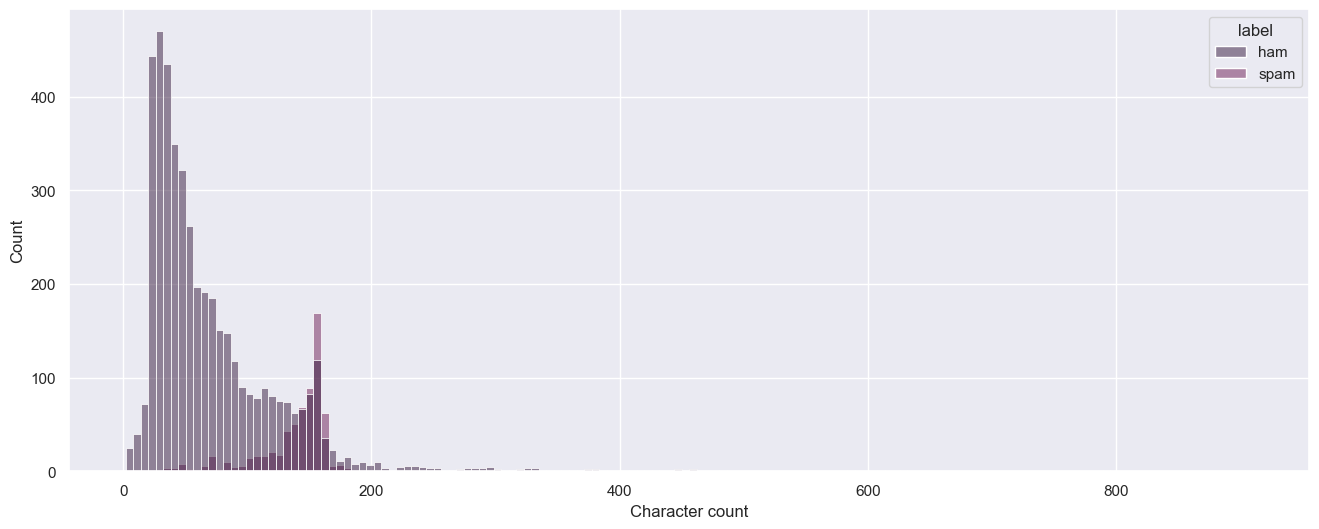

In [10]:
plt.figure(figsize=(16, 6))
sns.histplot(data=messages, x="char_count", bins=150, hue="label")
plt.xlabel("Character count")
plt.show()

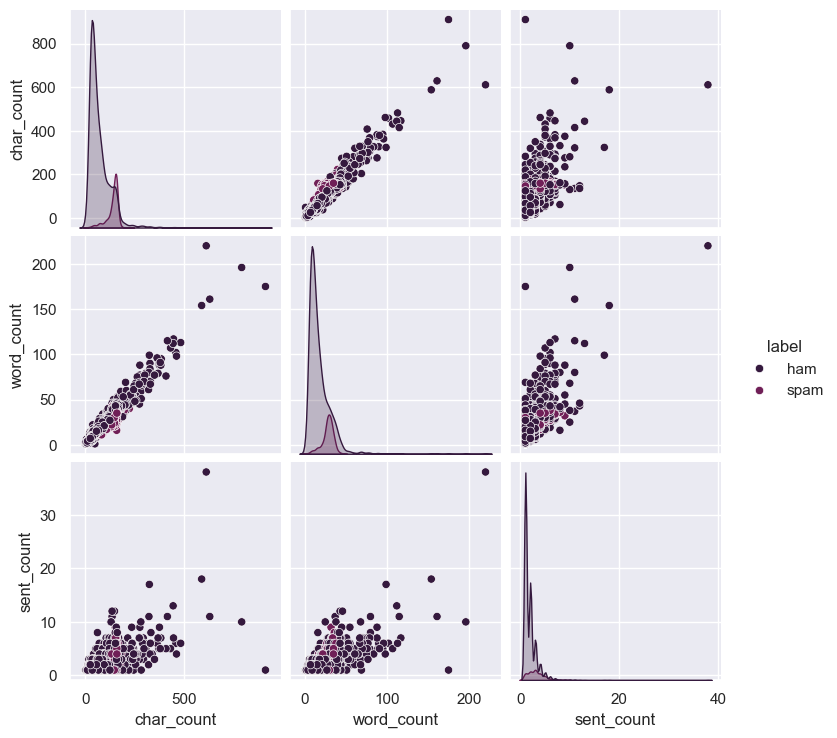

In [11]:
sns.pairplot(data=messages, hue="label")
plt.show()

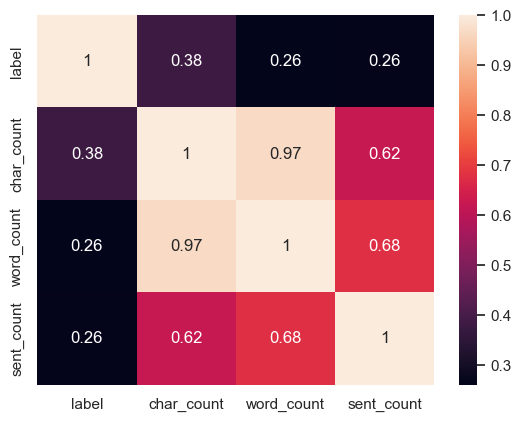

In [12]:
corr_dataframe = messages.copy().drop(columns=["message"])
corr_dataframe["label"] = corr_dataframe["label"].map({ "ham": 0, "spam": 1 })

sns.heatmap(corr_dataframe.corr(), annot=True)
plt.show()

# Data Preprocessing
- Conversion to lower case
- Removal of special characters and punctuation
- Tokenization
- Removal of stop words
- Stemming

In [13]:
def text_preprocess(message):
    # converting to lower case
    message = message.lower()

    # removing special characters and punctuation
    clean_message = "".join([char for char in message if char == " " or char.isalnum()])

    # tokenizing
    tokens = word_tokenize(clean_message)

    # removing stop words
    stopwords_list = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords_list]

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(tokens)

In [14]:
messages["transformed_message"] = messages["message"].apply(text_preprocess)

In [15]:
messages.head()

,label,message,char_count,word_count,sent_count,transformed_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah dont think go usf life around though


# Exploratory Data Analysis (Cont.)

In [16]:
spam_msgs_string = messages[messages["label"] == "spam"]["transformed_message"].str.cat(sep=" ")
ham_msgs_string = messages[messages["label"] == "ham"]["transformed_message"].str.cat(sep=" ")

### Visualizing Wordcloud

In [17]:
def show_wordcloud(string):
    word_cloud_obj = WordCloud(width=500, height=500, min_font_size=10)
    word_cloud = word_cloud_obj.generate(string)

    plt.figure(figsize=(16, 6))
    plt.grid(visible=False)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

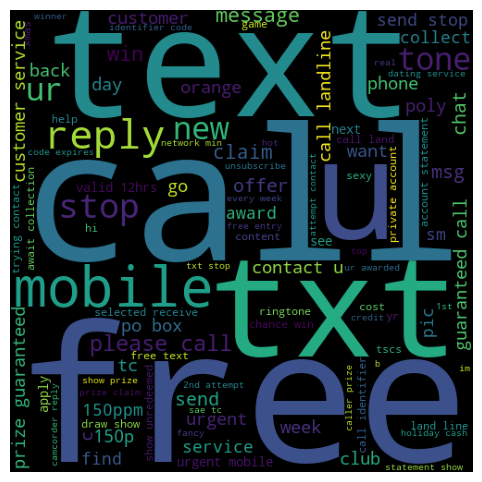

In [18]:
show_wordcloud(spam_msgs_string)

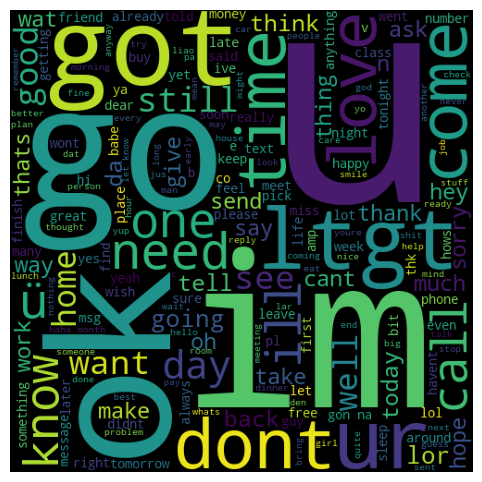

In [19]:
show_wordcloud(ham_msgs_string)

### Most frequent terms

In [20]:
def plot_most_frequent_words(most_common = 30):
    spam_word_count_dict = Counter(spam_msgs_string.split()).most_common(most_common)
    spam_word_freq_df = pd.DataFrame(spam_word_count_dict, columns=["word", "count"])

    ham_word_count_dict = Counter(ham_msgs_string.split()).most_common(most_common)
    ham_word_freq_df = pd.DataFrame(ham_word_count_dict, columns=["word", "count"])

    plt.figure(figsize=(16, 6))
    plt.suptitle("Frequent words")

    plt.subplot(1, 2, 1)
    plt.title("Frequent words in SPAM messages")
    sns.barplot(data=spam_word_freq_df, x="word", y="count", hue="word", palette="rocket")
    plt.xticks(rotation="vertical")


    plt.subplot(1, 2, 2)
    plt.title("Frequent words in HAM messages")
    sns.barplot(data=ham_word_freq_df, x="word", y="count", hue="word", palette="rocket")
    plt.xticks(rotation="vertical")

    plt.tight_layout(pad=2)
    plt.show()

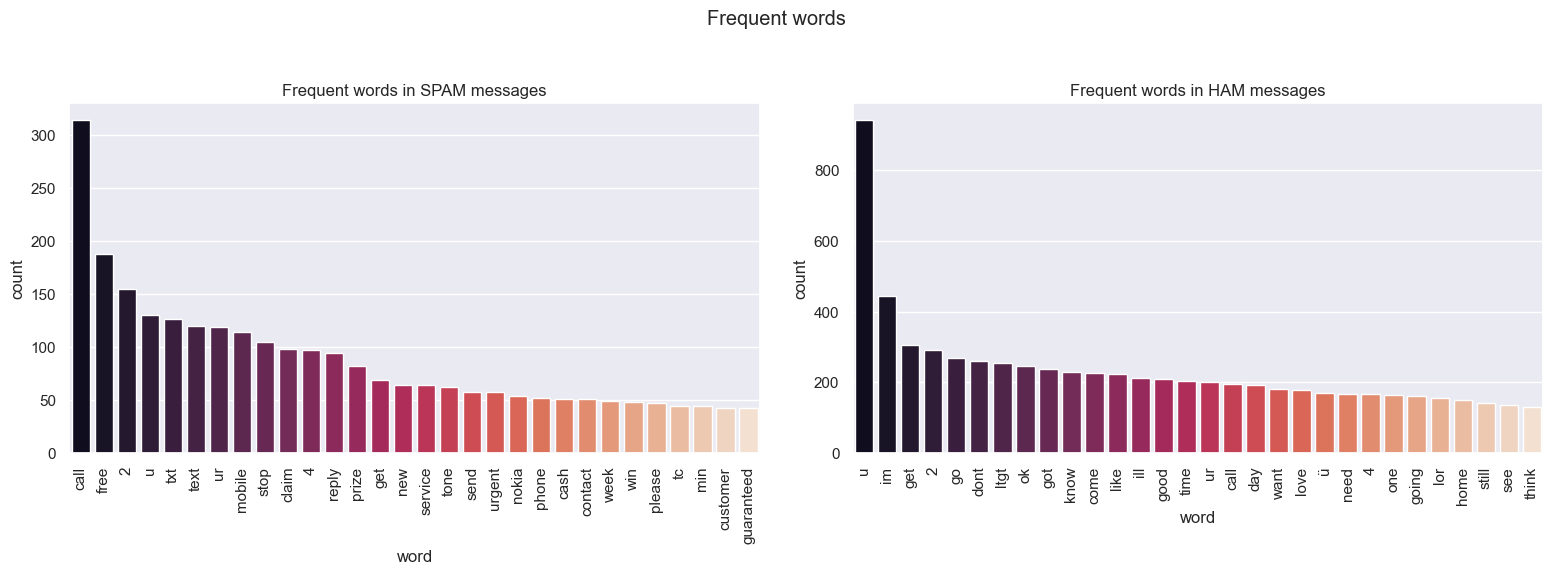

In [21]:
plot_most_frequent_words()

# Vectorization

In [22]:
vectorizer = TfidfVectorizer(max_features=3000)

X = vectorizer.fit_transform(messages["transformed_message"]).toarray()
y = messages["label"].map({"ham": 0, "spam": 1}).values

# Model training

## Hypertuning all models
- Logistic Regression
- Support Vector Classification
- Gaussian Naive Bayes Classification
- Bernoulli Naive Bayes Classification
- Multinomial Naive Bayes Classification
- Decision Tree Classification
- K-Nearest Neighbors Classification
- Random Forest Classification
- Ada Boost Classification
- Bagging Classification
- Extra Trees Classification
- Gradient Boosting Classification
- XGB Classification

In [23]:
# def custom_scorer(y_true, y_pred):
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, zero_division=0)
#     return 0.7 * precision + 0.3 * accuracy

In [24]:
# kernels = ["rbf", "sigmoid"]
# gamma_ls = [0.01, 0.1, 1, 10, 100, "scale", "auto"]
# C_ls = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

# best_score = 0
# best_params = {}

# import warnings
# warnings.filterwarnings('ignore')

# for kernel in kernels:
#     for gamma in gamma_ls:
#         local_best_score = 0

#         for C in C_ls:
#             print(f"\nChecking for kernel={kernel}, gamma={gamma}, C={C}")
#             try:
#                 model = SVC(kernel=kernel, gamma=gamma, C=C, random_state=42)
#                 skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#                 scores = []

#                 for train_index, test_index in skf.split(X, y):
#                     X_train, X_test = X[train_index], X[test_index]
#                     y_train, y_test = y[train_index], y[test_index]
                
#                     model.fit(X_train, y_train)
#                     y_pred = model.predict(X_test)

#                     scores.append(custom_scorer(y_test, y_pred))

#                 score = np.mean(scores)
#                 print(score)
                
#                 if score >= best_score:
#                     best_score = score
#                     best_params = {"kernel": kernel, "gamma": gamma, "C": C}

#                 if score >= local_best_score:
#                     local_best_score = score
#                 else:
#                     break

#             except Exception as e:
#                 print("exception")
#                 break

In [25]:
# best_params

In [26]:
# best_score

In [27]:
classifiers = [
    {
        "algorithm": "Logistic Regression",
        "model": LogisticRegression(solver="saga", penalty="l2", C=10, random_state=42),
    },
    {
        "algorithm": "Support Vector Machine",
        "model": SVC(kernel="rbf", gamma=1.0, C=100, random_state=42),
    },
    {
        "algorithm": "Gaussian Naive Bayes",
        "model": GaussianNB(),
    },
    {
        "algorithm": "Bernoulli Naive Bayes",
        "model": BernoulliNB(alpha=0.3, binarize=None, fit_prior=True),
    },
    {
        "algorithm": "Multinomial Naive Bayes",
        "model": MultinomialNB(alpha=0.8, fit_prior=True),
    },
    {
        "algorithm": "Decision Tree",
        "model": DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42),
    },
    {
        "algorithm": "K-Nearest Neighbors",
        "model": KNeighborsClassifier(n_neighbors=2, weights="distance", p=1),
    },
    {
        "algorithm": "Random Forest",
        "model": RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_split=10, random_state=42),
    },
    {
        "algorithm": "Ada Boost",
        "model": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, algorithm="SAMME", random_state=42),
    },
    {
        "algorithm": "Bagging",
        "model": BaggingClassifier(n_estimators=50, max_samples=1.0, max_features=0.2, random_state=42),
    },
    {
        "algorithm": "Extra Trees",
        "model": ExtraTreesClassifier(n_estimators=150, max_depth=None, min_samples_split=10, random_state=42),
    },
    {
        "algorithm": "Gradient Boosting",
        "model": GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42),
    },
    {
        "algorithm": "XGBoost",
        "model": XGBClassifier(n_estimators=100, learning_rate=0.3, max_depth=5, random_state=42),
    },
]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
results = []

for classifier in classifiers:
    print(f'Running {classifier["algorithm"]}')
    model = classifier["model"]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)

    results.append([classifier["algorithm"], accuracy, precision])

print()
results = pd.DataFrame(results, columns=["Algorithm", "Accuracy", "Precision"])
results.sort_values(by=["Precision", "Accuracy"], ascending=False)

Running Logistic Regression
Running Support Vector Machine
Running Gaussian Naive Bayes
Running Bernoulli Naive Bayes
Running Multinomial Naive Bayes
Running Decision Tree
Running K-Nearest Neighbors
Running Random Forest
Running Ada Boost
Running Bagging
Running Extra Trees
Running Gradient Boosting
Running XGBoost



,Algorithm,Accuracy,Precision
3,Bernoulli Naive Bayes,0.984526,1.000000
9,Bagging,0.971954,1.000000
8,Ada Boost,0.882012,1.000000
7,Random Forest,0.974855,0.991379
6,K-Nearest Neighbors,0.940039,0.987500
4,Multinomial Naive Bayes,0.979691,0.983740
11,Gradient Boosting,0.969052,0.982143
12,XGBoost,0.974855,0.975000
1,Support Vector Machine,0.975822,0.967480
10,Extra Trees,0.977756,0.960630


## Improving model performance

1. **Selection of max_features parameter for tfidf vectorizer**

    Best performance observed at value 3000

2. **Voting model for best performing models**

    Performance decreased

3. **Stacking model for best performing models**

    Performance decreased

### Choosing Bernoulli naive bayes model

In [39]:
import pickle as pkl
model = classifiers[3]["model"]

pkl.dump(model, open("./../models/model.pkl", "wb"))
pkl.dump(vectorizer, open("./../models/vectorizer.pkl", "wb"))